In [ ]:
from google.colab import drive

# Montar o Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install torch torchvision opencv-python


In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import densenet121
import torchvision.transforms as transforms

class CustomDataset(Dataset):
    def __init__(self, caminhos_imagens, labels):
        self.imagens = self.carregar_imagens(caminhos_imagens)
        self.labels = labels

    def __len__(self):
        return len(self.imagens)

    def __getitem__(self, index):
        imagem = self.imagens[index]
        label = self.labels[index]
        return imagem, torch.tensor(label)

    def carregar_imagens(self, caminhos_imagens):
        imagens = []
        for caminho_imagem in caminhos_imagens:
            imagem = cv2.imread(caminho_imagem)
            if imagem is None:
                continue
            imagem = cv2.resize(imagem, (128, 128))
            imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
            imagem = torch.tensor(imagem, dtype=torch.float32)
            # Transpor as dimensões das imagens para [3, 128, 128]
            imagem = imagem.permute(2, 0, 1)
            imagens.append(imagem)
        return imagens

class DenseNet(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet, self).__init__()
        self.densenet = densenet121(pretrained=True)
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.densenet(x)

# Caminho para a pasta que contém as imagens
pasta_imagens = "/content/drive/MyDrive/compara_segmentadores/data2/A/DRIVEpng/train/images"

# Caminho para a pasta que contém as anotações (rótulos)
pasta_anotacoes = "/content/drive/MyDrive/compara_segmentadores/data2/A/DRIVEpng/train/mask"

# Lista para armazenar os caminhos das imagens e rótulos
arquivos_imagens = []
arquivos_anotacoes = []

# Percorrer as subpastas "classe 0" e "classe 1"
for classe in ["classe 0", "classe 1"]:
    subpasta_imagens = os.path.join(pasta_imagens, classe)
    subpasta_anotacoes = os.path.join(pasta_anotacoes, classe)
    
    # Obter os caminhos dos arquivos de imagem e anotação (rótulo)
    arquivos_imagens_classe = [os.path.join(subpasta_imagens, nome) for nome in os.listdir(subpasta_imagens)]
    arquivos_anotacoes_classe = [os.path.join(subpasta_anotacoes, nome) for nome in os.listdir(subpasta_anotacoes)]
    
    # Adicionar os caminhos à lista principal
    arquivos_imagens.extend(arquivos_imagens_classe)
    arquivos_anotacoes.extend(arquivos_anotacoes_classe)

if len(arquivos_imagens) == 0 or len(arquivos_anotacoes) == 0:
    print("Nenhum dado válido encontrado. Verifique os caminhos dos arquivos.")
    exit()

# Converter os rótulos para tipo numérico (classe 0: 0, classe 1: 1)
labels = [0 if "classe 0" in arquivo else 1 for arquivo in arquivos_anotacoes]

# Carregar as imagens e rótulos
imagens = CustomDataset(arquivos_imagens, labels)

# Criar DataLoader
dataloader = DataLoader(imagens, batch_size=32, shuffle=True)

# Definir número de classes (glaucoma ou não glaucoma)
num_classes = 2

# Criar modelo DenseNet
model = DenseNet(num_classes)

# Definir função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Verificar se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Treinar o modelo
num_epochs = 10
for epoch in range(num_epochs):
    for imagens_batch, labels_batch in dataloader:
        imagens_batch = imagens_batch.to(device)
        labels_batch = labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(imagens_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Salvar o modelo treinado
nome_arquivo_modelo = "modeloDesnetDRIVE.pth"
torch.save(model.state_dict(), nome_arquivo_modelo)
print("Modelo salvo com sucesso!")


In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import densenet121
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class CustomDataset(Dataset):
    def __init__(self, caminhos_imagens, labels):
        self.imagens = self.carregar_imagens(caminhos_imagens)
        self.labels = labels

    def __len__(self):
        return len(self.imagens)

    def __getitem__(self, index):
        imagem = self.imagens[index]
        label = self.labels[index]
        return imagem, label[0]
 

    def carregar_imagens(self, caminhos_imagens):
        imagens = []
        labels = []
        for caminho_imagem in caminhos_imagens:
            imagem = cv2.imread(caminho_imagem)
            if imagem is None:
                continue
            imagem = cv2.resize(imagem, (128, 128))
            imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
            imagens.append(imagem)
    
            # Obter o rótulo da imagem a partir do caminho
            label = os.path.basename(os.path.dirname(caminho_imagem))
            labels.append(label)
    
        return np.array(imagens), labels


class DenseNet(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet, self).__init__()
        self.densenet = densenet121(pretrained=False, num_classes=num_classes)

    def forward(self, x):
        return self.densenet(x)

# Caminho para a pasta que contém as imagens
pasta_imagens = "/content/drive/MyDrive/compara_segmentadores/data2/A/DRIVEpng/train/images"

# Caminho para a pasta que contém as anotações (rótulos)
pasta_anotacoes = "/content/drive/MyDrive/compara_segmentadores/data2/A/DRIVEpng/train/mask"

# Lista para armazenar os caminhos das imagens e rótulos
arquivos_imagens = []
arquivos_anotacoes = []

# Percorrer as subpastas "classe 0" e "classe 1"
for classe in ["classe 0", "classe 1"]:
    subpasta_imagens = os.path.join(pasta_imagens, classe)
    subpasta_anotacoes = os.path.join(pasta_anotacoes, classe)
    
    # Obter os caminhos dos arquivos de imagem e anotação (rótulo)
    arquivos_imagens_classe = [os.path.join(subpasta_imagens, arquivo) for arquivo in os.listdir(subpasta_imagens)]
    arquivos_anotacoes_classe = [os.path.join(subpasta_anotacoes, arquivo) for arquivo in os.listdir(subpasta_anotacoes)]
    
    # Adicionar os caminhos à lista geral
    arquivos_imagens.extend(arquivos_imagens_classe)
    arquivos_anotacoes.extend(arquivos_anotacoes_classe)

# Verificar se há dados carregados
if len(arquivos_imagens) == 0 or len(arquivos_anotacoes) == 0:
    print("Nenhum dado válido encontrado. Verifique os caminhos dos arquivos.")
    exit()

# Carregar as imagens e anotações
imagens = CustomDataset(arquivos_imagens, arquivos_anotacoes)

# Criar DataLoader
dataloader = DataLoader(imagens, batch_size=32, shuffle=True)

# Definir número de classes (glaucoma ou não glaucoma)
num_classes = 2

# Criar modelo DenseNet
model = DenseNet(num_classes)

# Definir função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Verificar se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Treinar o modelo
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_acc = 0.0
    epoch_precision = 0.0
    epoch_recall = 0.0
    epoch_f1 = 0.0
    
    for imagens_batch, labels_batch in dataloader:
        imagens_batch = imagens_batch.to(device)
        labels_batch = [int(label) for label in labels_batch]
        labels_batch = torch.tensor(labels_batch, dtype=torch.long)
        labels_batch = labels_batch.to(device)

         
        
        optimizer.zero_grad()
        outputs = model(imagens_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
    
    # Resto do código...

        
        epoch_loss += loss.item() * imagens_batch.size(0)
        
        _, predicted_labels = torch.max(outputs, 1)
        predicted_labels = predicted_labels.cpu().numpy()
        labels_batch = labels_batch.cpu().numpy()
        
        epoch_acc += accuracy_score(labels_batch, predicted_labels) * imagens_batch.size(0)
        epoch_precision += precision_score(labels_batch, predicted_labels) * imagens_batch.size(0)
        epoch_recall += recall_score(labels_batch, predicted_labels) * imagens_batch.size(0)
        epoch_f1 += f1_score(labels_batch, predicted_labels) * imagens_batch.size(0)
    
    epoch_loss /= len(imagens)
    epoch_acc /= len(imagens)
    epoch_precision /= len(imagens)
    epoch_recall /= len(imagens)
    epoch_f1 /= len(imagens)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, F1-score: {epoch_f1:.4f}")

# Salvar o modelo treinado
nome_arquivo_modelo = "/content/drive/MyDrive/compara_segmentadores/data2/A/DRIVEpng/"
model.save(nome_arquivo_modelo)
print("Modelo salvo com sucesso!")


AttributeError: ignored

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize, Compose
from PIL import Image
import torchvision.models as models

# Definir a classe do conjunto de dados
class GlaucomaDataset(Dataset):
    def __init__(self, root_dir, annotation_dir, transform=None, train=True):
        self.root_dir = root_dir
        self.annotation_dir = annotation_dir
        self.classes = ['classe 0', 'classe 1']
        self.transform = transform
        self.train = train
        self.images = []
        self.labels = []
        self.annotations = []
        for class_idx, class_dir in enumerate(self.classes):
            class_path = os.path.join(self.root_dir, class_dir)
            annotation_path = os.path.join(self.annotation_dir, class_dir)
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.images.append(image_path)
                self.labels.append(class_idx)
                annotation_name = image_name.replace('.png', '.txt')
                annotation_file = os.path.join(annotation_path, annotation_name)
                self.annotations.append(annotation_file)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx], cv2.IMREAD_UNCHANGED)  # Carregar a imagem no formato PNG
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        annotation = self.annotations[idx]

        if self.train:
            return image, label, annotation
        else:
            return image, label


# Definir as transformações a serem aplicadas nas imagens
transform = Compose([
    Resize((128, 128)),
    ToTensor()
])

# Definir a arquitetura DenseNet
class DenseNet(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.densenet(x)


# Definir os caminhos para as pastas de treinamento e teste
train_folder = "/content/drive/MyDrive/compara_segmentadores/data2/A/G1020/treino"
train_annotation_folder = "/content/drive/MyDrive/compara_segmentadores/data2/A/G1020/anotacoes tr"

test_folder = "/content/drive/MyDrive/compara_segmentadores/data2/A/G1020/valid"
test_annotation_folder = "/content/drive/MyDrive/compara_segmentadores/data2/A/G1020/anotacoes vd"

# Criar o conjunto de dados de treinamento e teste
train_dataset = GlaucomaDataset(train_folder, train_annotation_folder, transform=transform, train=True)
test_dataset = GlaucomaDataset(test_folder, test_annotation_folder, transform=transform, train=False)

# Criar os dataloaders para carregar os dados durante o treinamento e teste
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Criar a instância do modelo DenseNet
model = DenseNet(num_classes=1)

# Definir a função de perda e o otimizador
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Treinar o modelo
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels, _ in train_dataloader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Avaliar o modelo após cada epoch
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Accuracy: {accuracy:.4f}")
    # Salvar o modelo treinado
    nome_arquivo_modelo = "/content/drive/MyDrive/compara_segmentadores/data2/A/DRIVEpng/ops4.pth"
    torch.save(model.state_dict(), nome_arquivo_modelo)
    print("Modelo salvo com sucesso!")  

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 2.5233
Epoch 1/10, Accuracy: 0.6000
Modelo salvo com sucesso!
Epoch 2/10, Loss: 0.6735
Epoch 2/10, Accuracy: 0.5143
Modelo salvo com sucesso!
Epoch 3/10, Loss: 0.6107
Epoch 3/10, Accuracy: 0.6000
Modelo salvo com sucesso!
Epoch 4/10, Loss: 0.6280
Epoch 4/10, Accuracy: 0.6000
Modelo salvo com sucesso!
Epoch 5/10, Loss: 0.6106
Epoch 5/10, Accuracy: 0.6000
Modelo salvo com sucesso!
Epoch 6/10, Loss: 0.6056
Epoch 6/10, Accuracy: 0.6000
Modelo salvo com sucesso!
Epoch 7/10, Loss: 0.6011
Epoch 7/10, Accuracy: 0.6000
Modelo salvo com sucesso!
Epoch 8/10, Loss: 0.6037
Epoch 8/10, Accuracy: 0.6000
Modelo salvo com sucesso!
Epoch 9/10, Loss: 0.6002
Epoch 9/10, Accuracy: 0.6000
Modelo salvo com sucesso!
Epoch 10/10, Loss: 0.5998
Epoch 10/10, Accuracy: 0.6000
Modelo salvo com sucesso!


In [ ]:
model.load_state_dict(torch.load(nome_arquivo_modelo))

<All keys matched successfully>

Performance metrics on the test set:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       447
           1       0.00      0.00      0.00       140

    accuracy                           0.76       587
   macro avg       0.38      0.50      0.43       587
weighted avg       0.58      0.76      0.66       587

-----------------------------------
Summary for 587 test images:
Accuracy: 76.15%
Precision: 38.07%
Recall: 50.00%
F1-score: 43.23%
-----------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

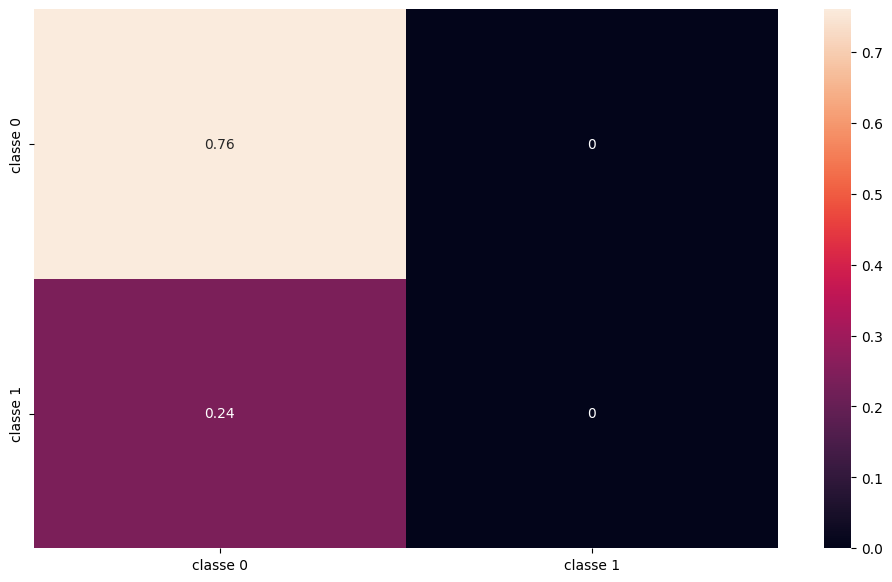

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import torchvision.models as models

# Define the neural network architecture with transfer learning
class GlaucomaClassifier(nn.Module):
    def __init__(self):
        super(GlaucomaClassifier, self).__init__()
        self.features = models.densenet121(pretrained=True)
        num_ftrs = self.features.classifier.in_features
        self.features.classifier = nn.Linear(num_ftrs, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.features(x)
        x = self.sigmoid(x)
        return x


# Define the desired size to resize the images
image_size = (224, 224)  # Replace with your desired sizes

# Transformation to resize the images
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = torchvision.datasets.ImageFolder("/content/drive/MyDrive/compara_segmentadores/data2/A/ORIGA/train/", transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)

model = GlaucomaClassifier()

# Load the state_dict from the saved model
state_dict = torch.load("/content/drive/MyDrive/compara_segmentadores/data2/A/DRIVEpng/ops4.pth")

# Load the adjusted state_dict into the model
model.load_state_dict(state_dict, strict=False)

# Move the model to the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Generate predictions for the test set
model.eval()
preds = []
targets = []

with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        _, predicted = torch.max(outputs, 1)

        preds.extend(predicted.cpu().numpy())
        targets.extend(labels.cpu().numpy())

# Calculate the confusion matrix
confusion_mat = confusion_matrix(targets, preds)

# Normalize the matrix to the range 0 and 1 and round each cell to 2 decimal places
normalized_mat = np.round(confusion_mat / np.sum(confusion_mat), 2)

# Convert the matrix to the format expected by the Pandas library
classes = dataset.classes
df_confusion = pd.DataFrame(normalized_mat, index=classes, columns=[i for i in classes])

# Generate a heatmap image
plt.figure(figsize=(12, 7))
sn.heatmap(df_confusion, annot=True)
plt.savefig('confusion_matrix.png')

# Print performance metrics
print('Performance metrics on the test set:')
print(classification_report(targets, preds))

precision, recall, fscore, support = precision_recall_fscore_support(targets, preds, average='macro')

print('-----------------------------------')
print(f'Summary for {len(dataset)} test images:')
print(f"Accuracy: {(100 * np.sum(np.array(preds) == np.array(targets)) / len(targets)):.2f}%")
print(f"Precision: {100 * precision:.2f}%")
print(f"Recall: {100 * recall:.2f}%")
print(f"F1-score: {100 * fscore:.2f}%")
print('-----------------------------------')


In [ ]:
import os 
from google.colab import drive
drive.mount('/content/drive')
print(os.listdir(('/content/drive/MyDrive/compara_segmentadores/data2/A/G1020/treino/classe 0')))
print(train_folder)

Mounted at /content/drive
['image_103.jpg', 'image_107.jpg', 'image_1076.jpg', 'image_1035.jpg', 'image_105.jpg', 'image_1087.jpg', 'image_1077.jpg', 'image_1092.jpg', 'image_104.jpg', 'image_1034.jpg', 'image_1088.jpg', 'image_106.jpg', 'image_1095.jpg', 'image_1096.jpg', 'image_1136.jpg', 'image_1137.jpg', 'image_1093.jpg', 'image_1094.jpg', 'image_1138.jpg', 'image_1141.jpg', 'image_1143.jpg', 'image_1142.jpg', 'image_1140.jpg', 'image_1144.jpg', 'image_1190.jpg', 'image_1161.jpg', 'image_1165.jpg', 'image_1160.jpg', 'image_1139.jpg', 'image_1189.jpg', 'image_1164.jpg', 'image_1188.jpg', 'image_1187.jpg', 'image_1218.jpg', 'image_1203.jpg', 'image_1217.jpg', 'image_1199.jpg', 'image_121.jpg', 'image_120.jpg', 'image_1204.jpg', 'image_1213.jpg', 'image_1216.jpg', 'image_1214.jpg', 'image_1198.jpg', 'image_1215.jpg', 'image_1197.jpg', 'image_1225.jpg', 'image_1242.jpg', 'image_124.jpg', 'image_122.jpg', 'image_123.jpg', 'image_1240.jpg', 'image_1243.jpg', 'image_1241.jpg', 'image_1238

In [ ]:
state_dict.keys()

odict_keys(['densenet.features.conv0.weight', 'densenet.features.norm0.weight', 'densenet.features.norm0.bias', 'densenet.features.norm0.running_mean', 'densenet.features.norm0.running_var', 'densenet.features.norm0.num_batches_tracked', 'densenet.features.denseblock1.denselayer1.norm1.weight', 'densenet.features.denseblock1.denselayer1.norm1.bias', 'densenet.features.denseblock1.denselayer1.norm1.running_mean', 'densenet.features.denseblock1.denselayer1.norm1.running_var', 'densenet.features.denseblock1.denselayer1.norm1.num_batches_tracked', 'densenet.features.denseblock1.denselayer1.conv1.weight', 'densenet.features.denseblock1.denselayer1.norm2.weight', 'densenet.features.denseblock1.denselayer1.norm2.bias', 'densenet.features.denseblock1.denselayer1.norm2.running_mean', 'densenet.features.denseblock1.denselayer1.norm2.running_var', 'densenet.features.denseblock1.denselayer1.norm2.num_batches_tracked', 'densenet.features.denseblock1.denselayer1.conv2.weight', 'densenet.features.den